In [237]:
# 1 Identification

# 1.1 check if the series is stationary
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from numpy import log

# Import Data
df = pd.read_csv('time_series_one_pixel.csv', parse_dates=['date'], index_col='date')

# check stationary (p<0.05, refuse the proposal)
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %f' % result[1])

ADF Statistic: -8.183049
Critical Test Statistics Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570
p-value: 0.000000


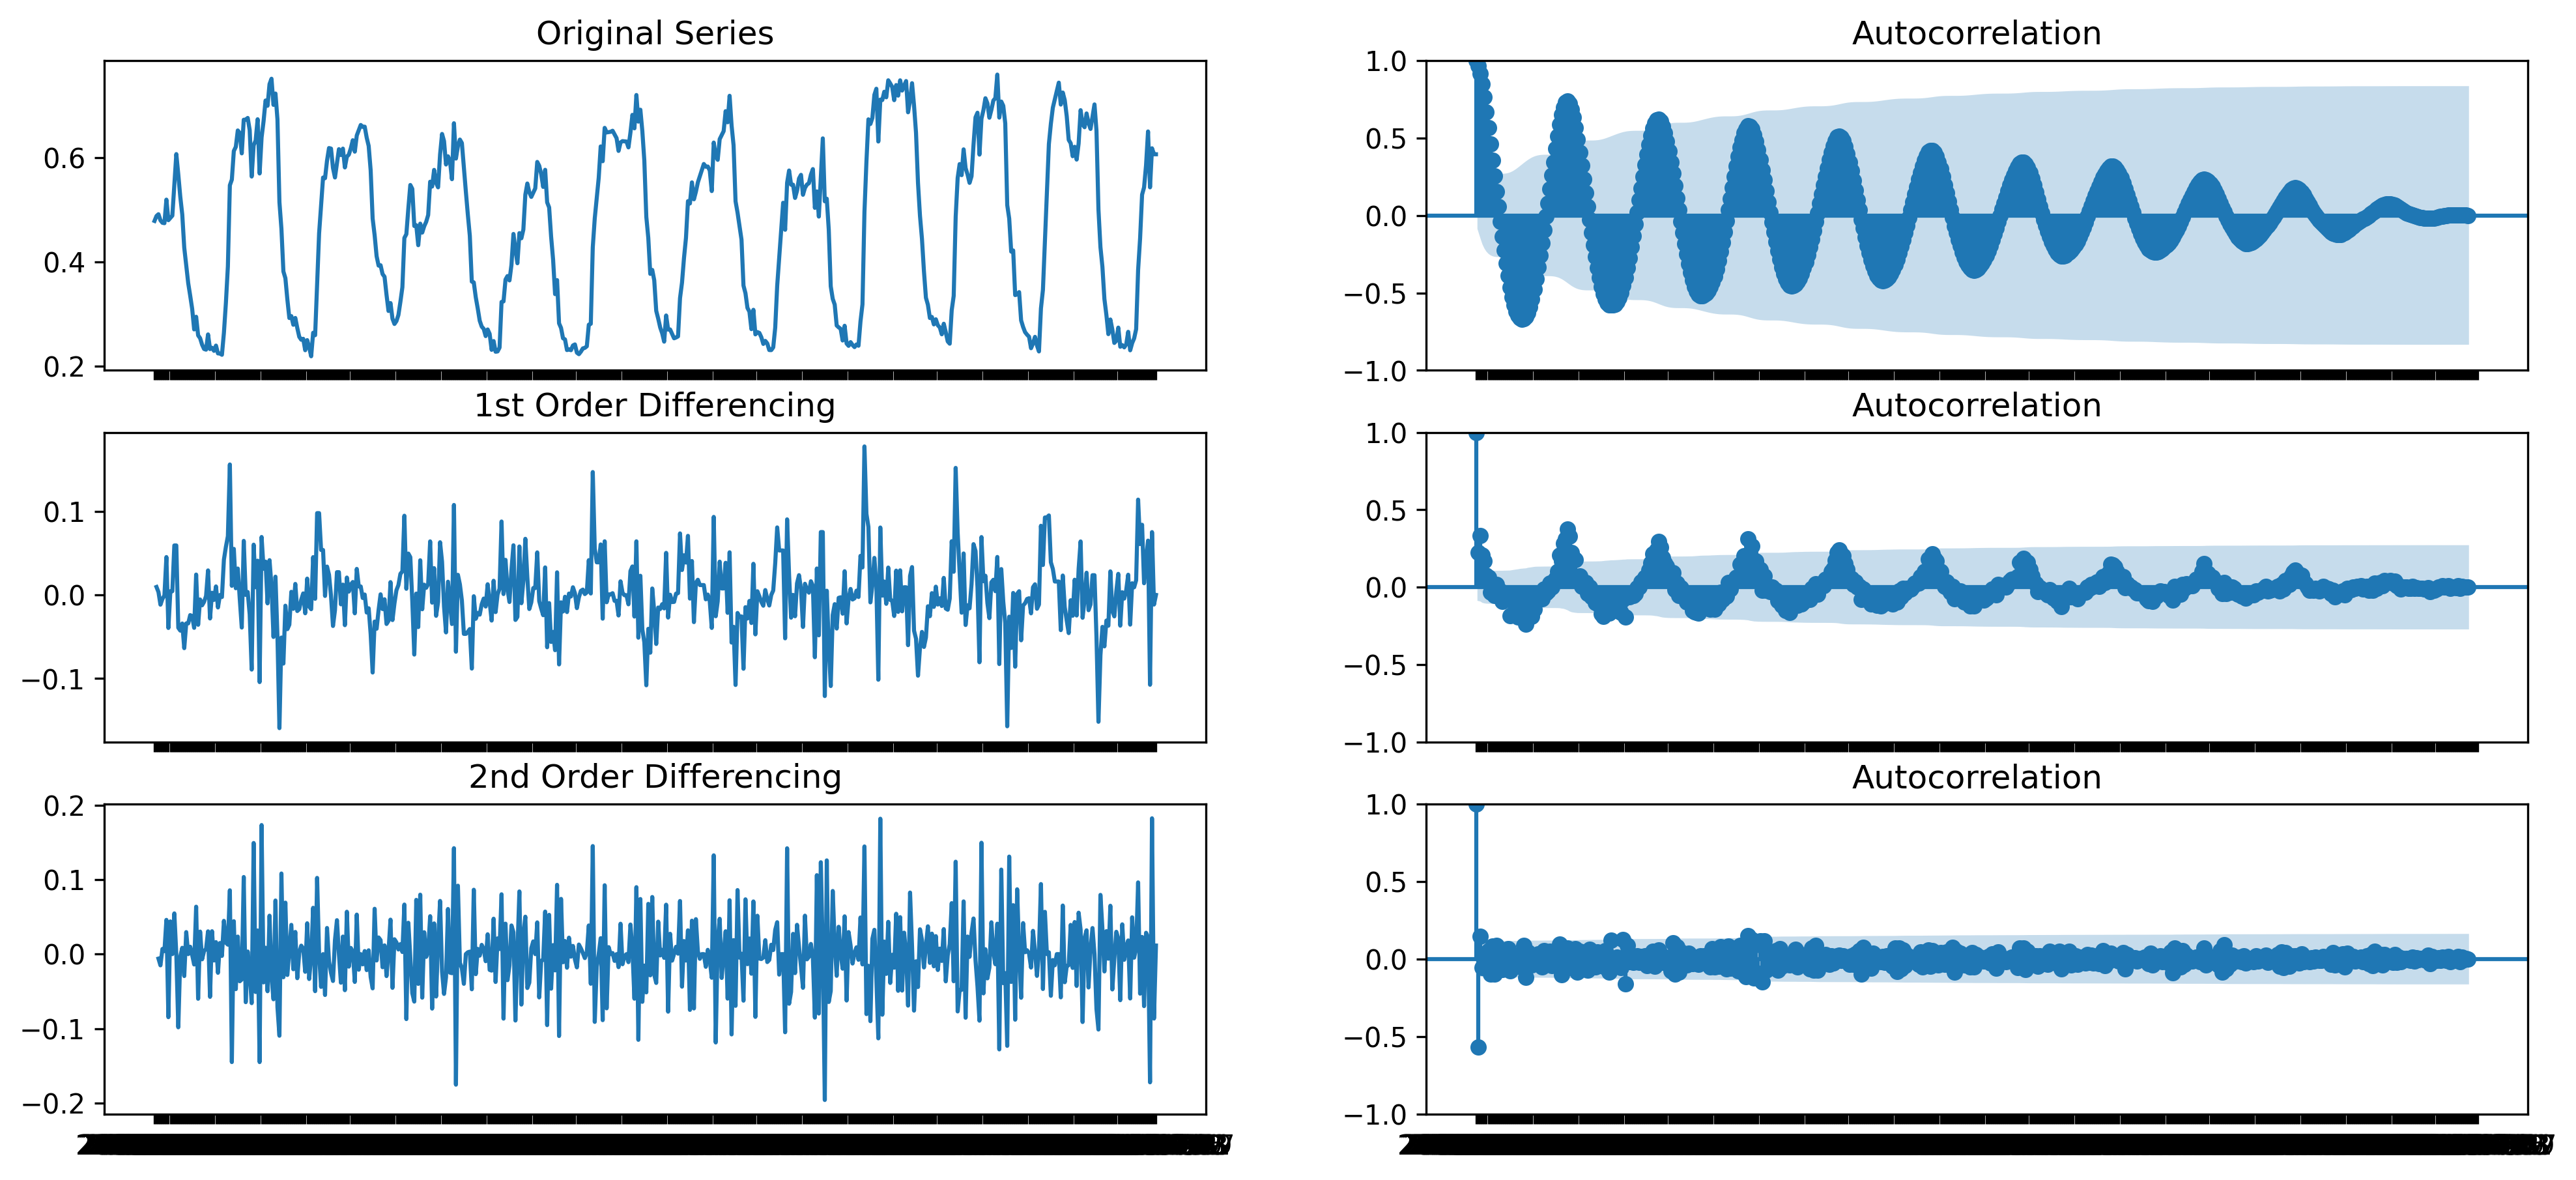

In [238]:
# 1.2 Differencing if not stationary
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(16,7), 'figure.dpi':300})

df = pd.read_csv('time_series_one_pixel.csv', names=['value'], header=0)
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, lags=500, ax=axes[0, 1])

# Differencing to address non-stationary data (while ours is already stationary)
# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), lags=500, ax=axes[1, 1])
# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), lags=500, ax=axes[2, 1])

plt.show()

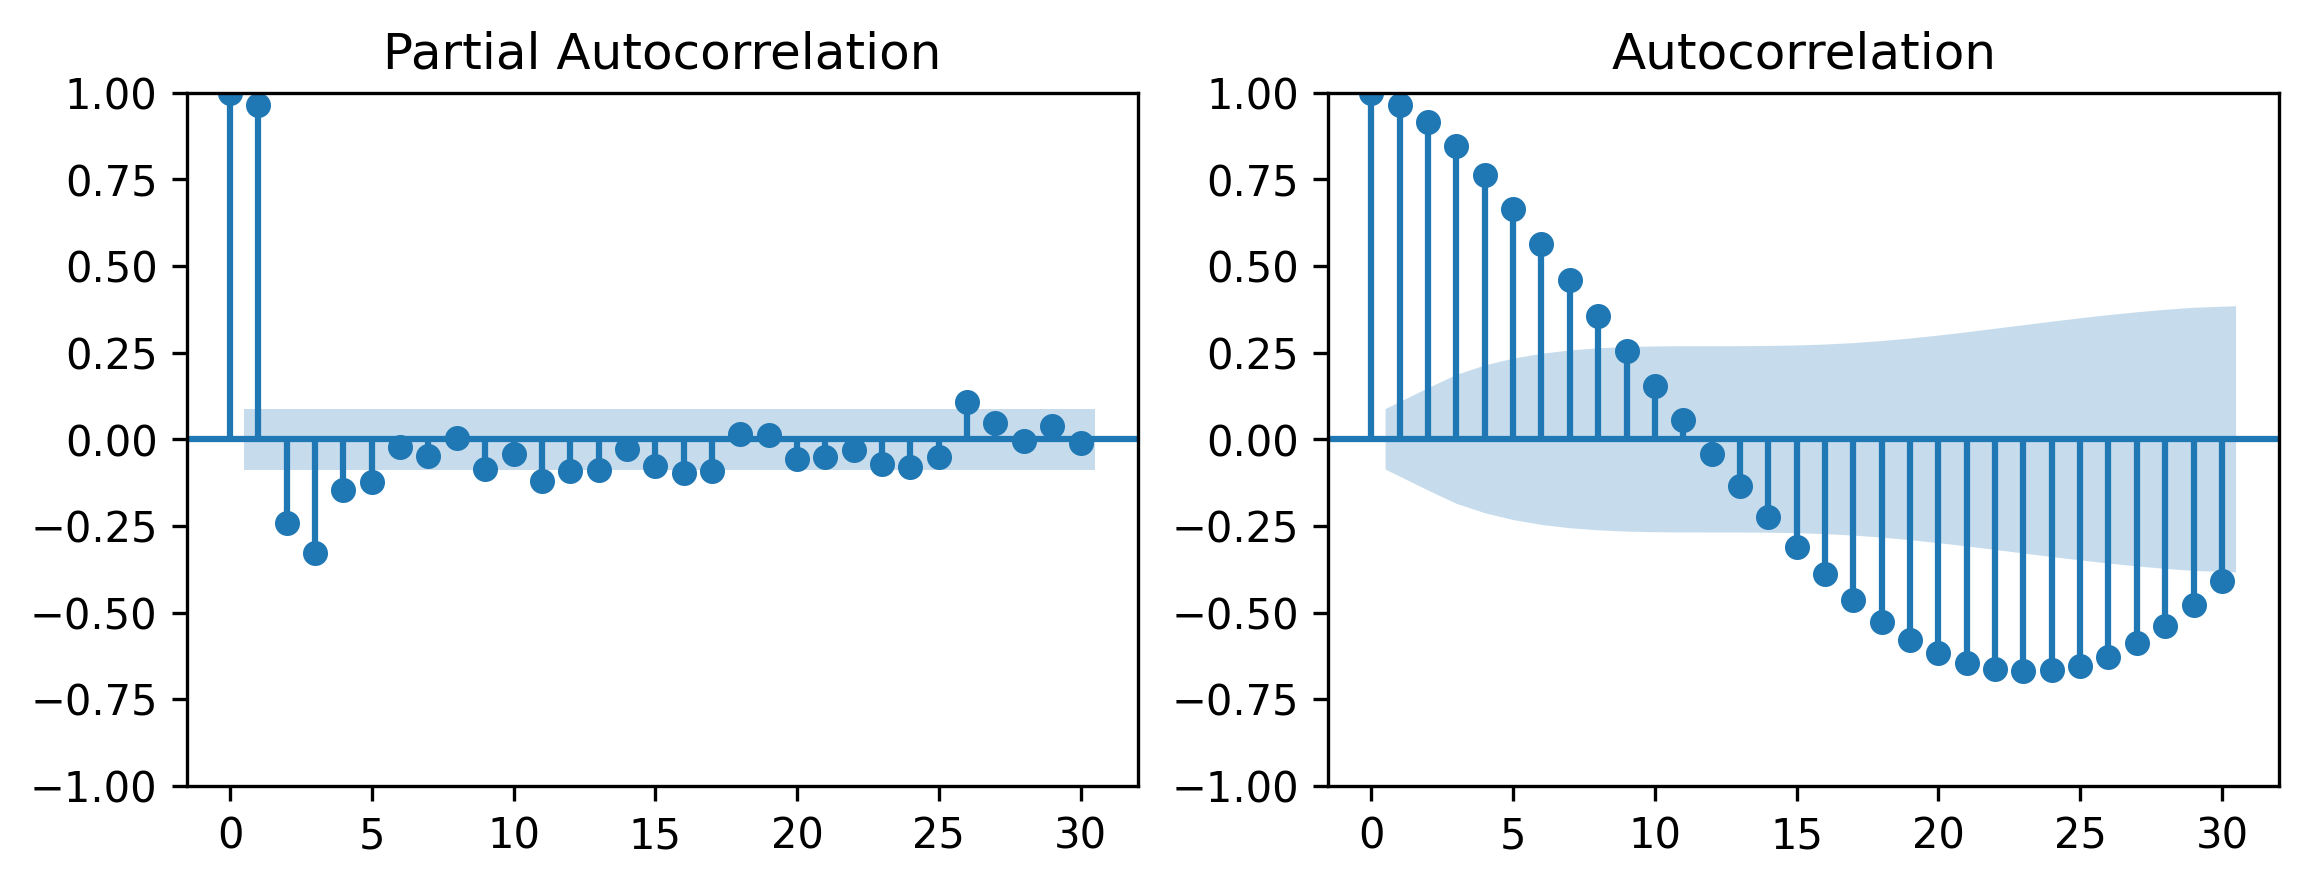

In [251]:
# 1.3 AR - MA identification

# PACF ACF plot of 1st differenced series => AR(1)
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':300})

fig, axes = plt.subplots(1, 2)
axes[0].set(ylim=(0,5))
plot_pacf(df.value.dropna(), lags=30, ax=axes[0], method='ywm')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.dropna(), lags=30, ax=axes[1])

plt.show()

/Users/yokosukamori/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yokosukamori/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yokosukamori/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                y_train   No. Observations:                  460
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 802.156
Date:                Fri, 19 Jan 2024   AIC                          -1598.312
Time:                        16:40:19   BIC                          -1585.918
Sample:                             0   HQIC                         -1593.432
                                - 460                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4858      0.061      7.997      0.000       0.367       0.605
ar.L1          0.9671      0.015     62.524      0.000       0.937       0.997
sigma2         0.0018      0.000     17.404      0.0

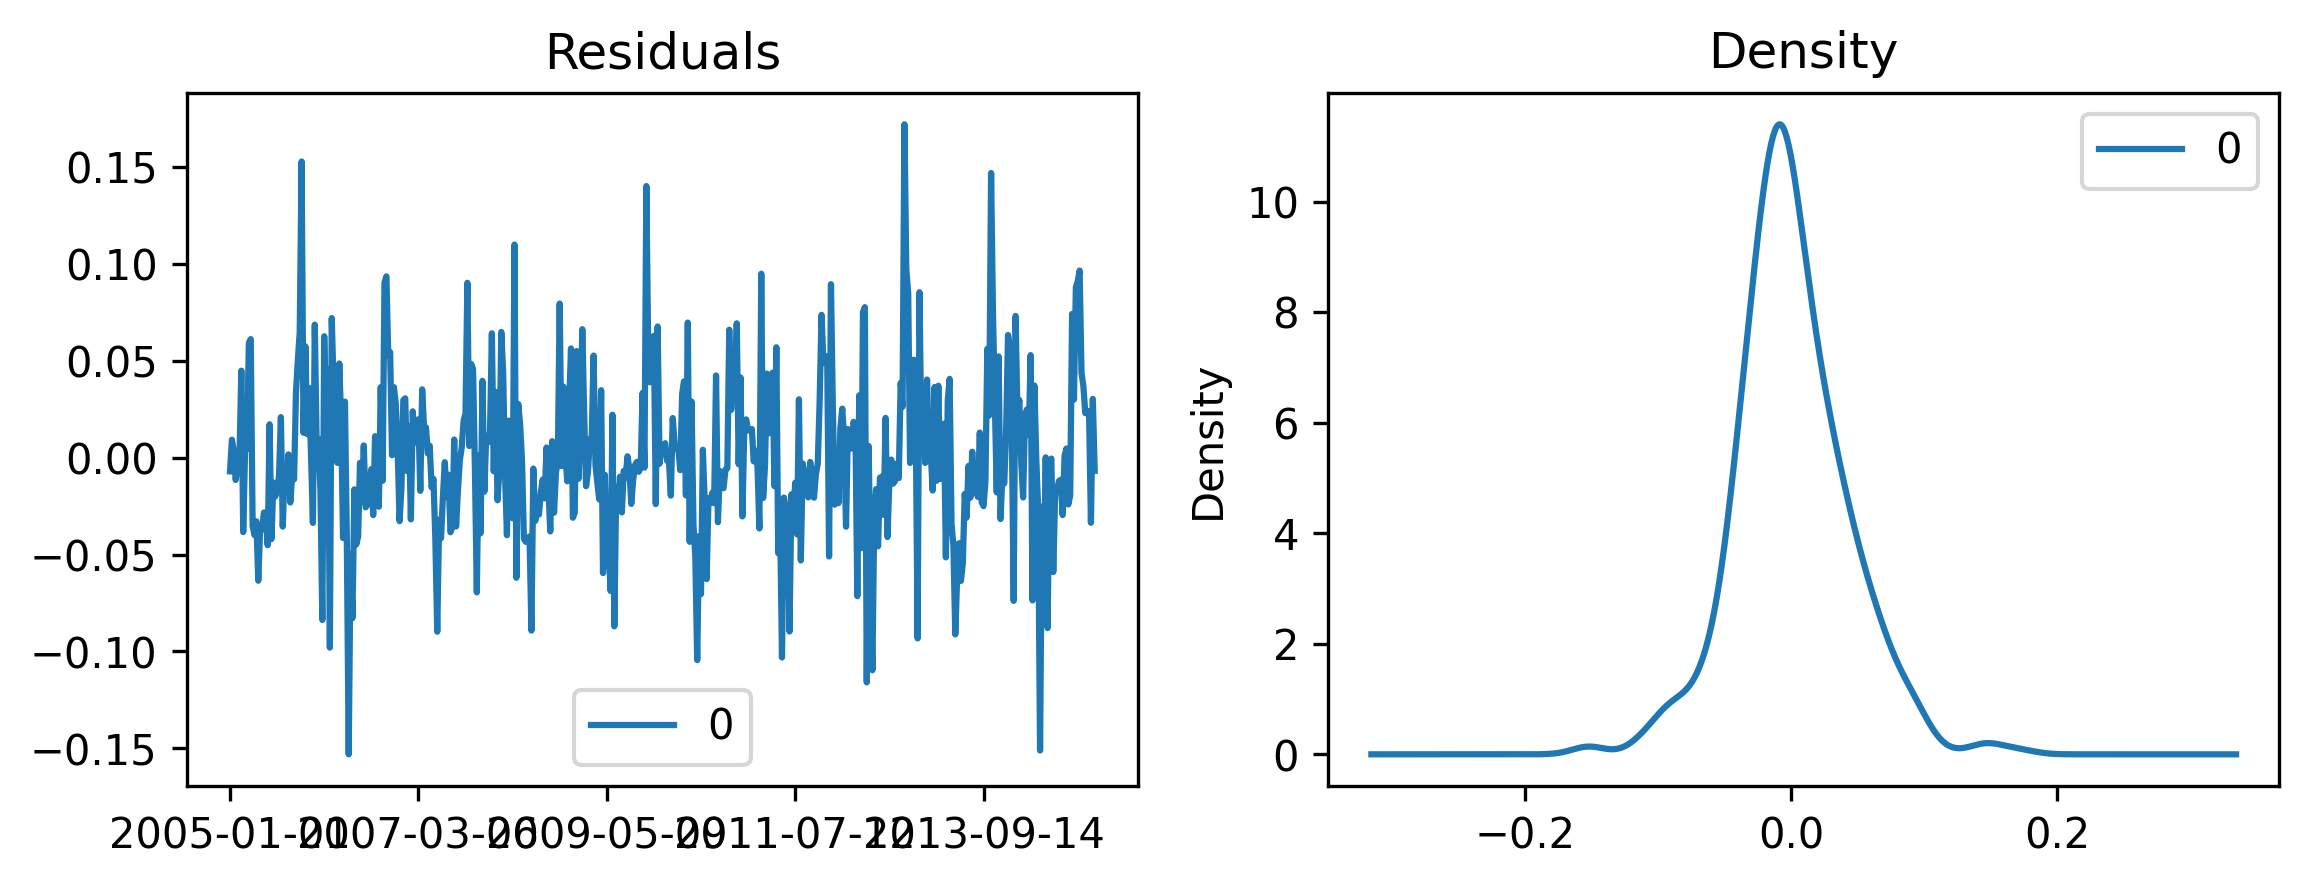

In [262]:
# 2 Estimation
from statsmodels.tsa.arima.model import ARIMA 

pred_periods = 46
split_number = df['value'].count() - pred_periods # corresponds to a prediction horizion of 1 years
train = pd.DataFrame(df['value'][:split_number]).rename(columns={'value':'y_train'})
test = pd.DataFrame(df['value'][split_number:]).rename(columns={'value':'y_test'})

#p=1，d=0，q=0  
arima_model=ARIMA(train, order=(1,0,0))
model = arima_model.fit()
print(model.summary())

# Plot residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


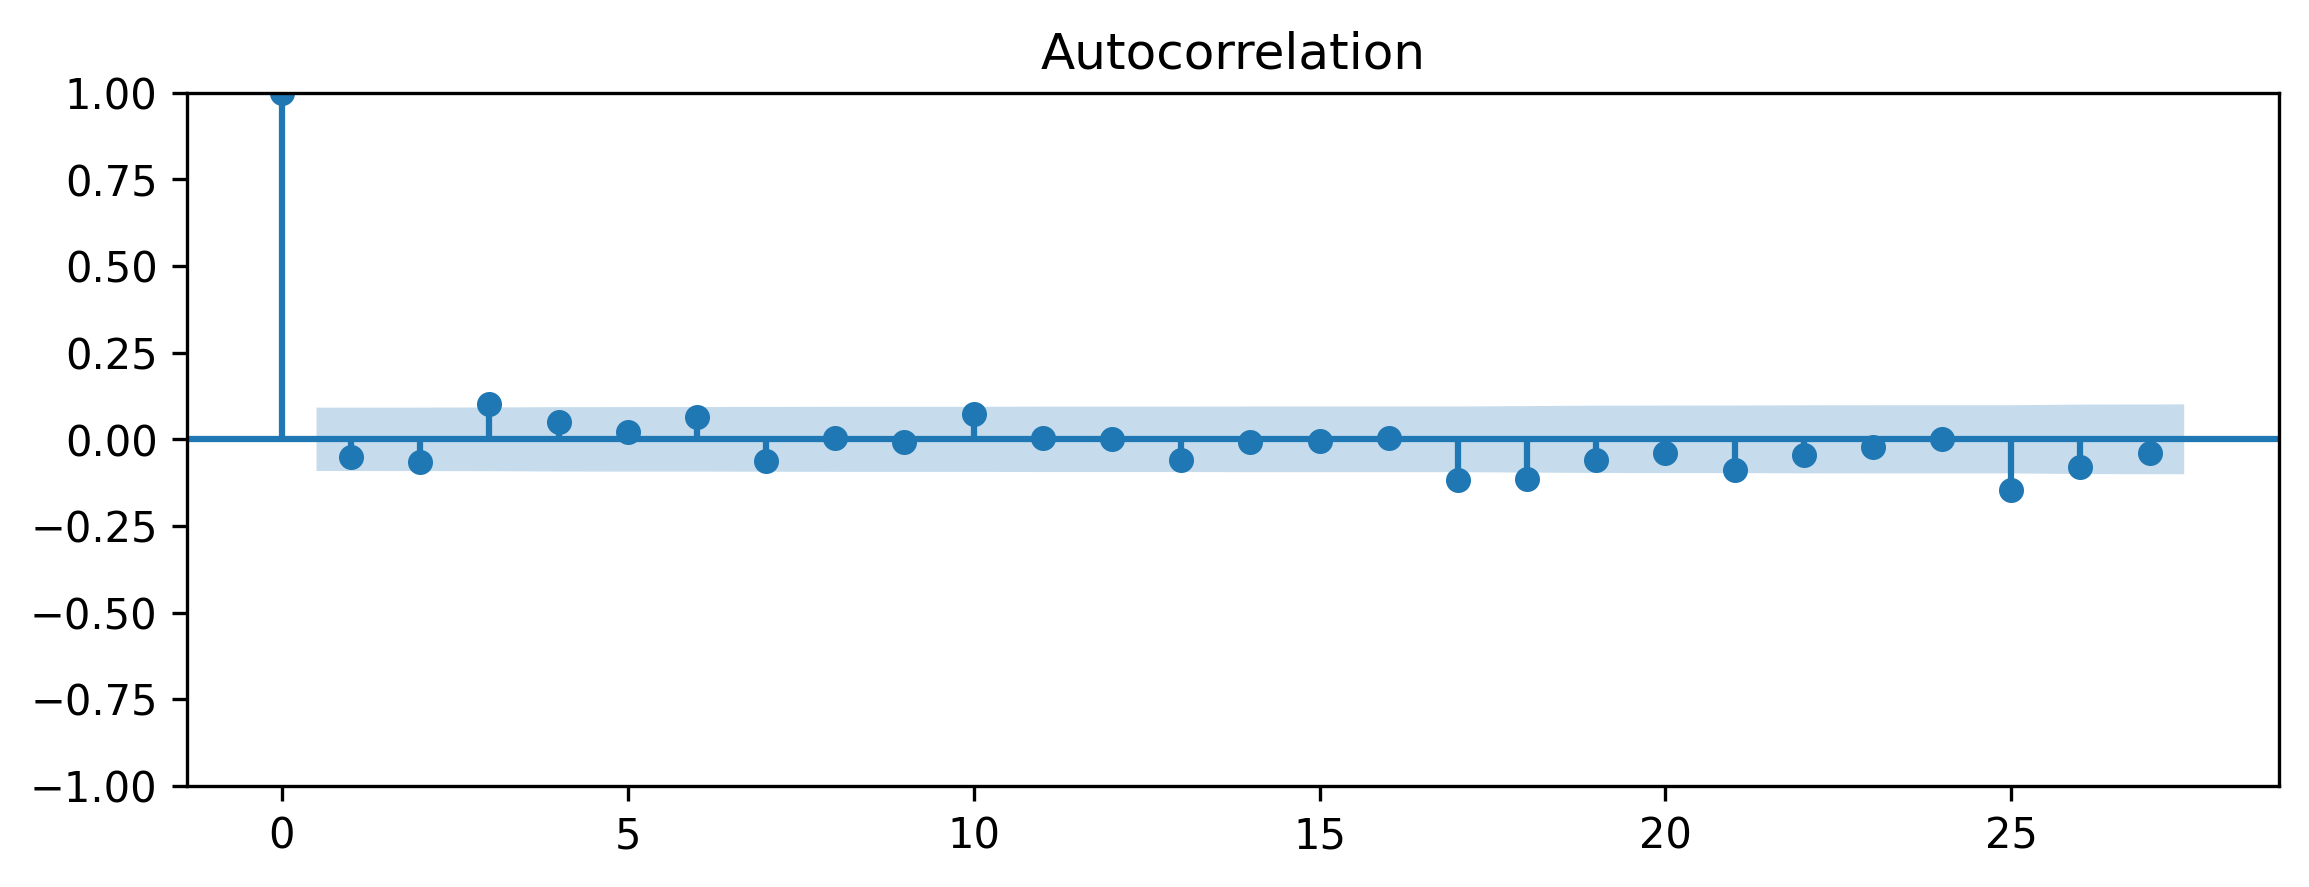

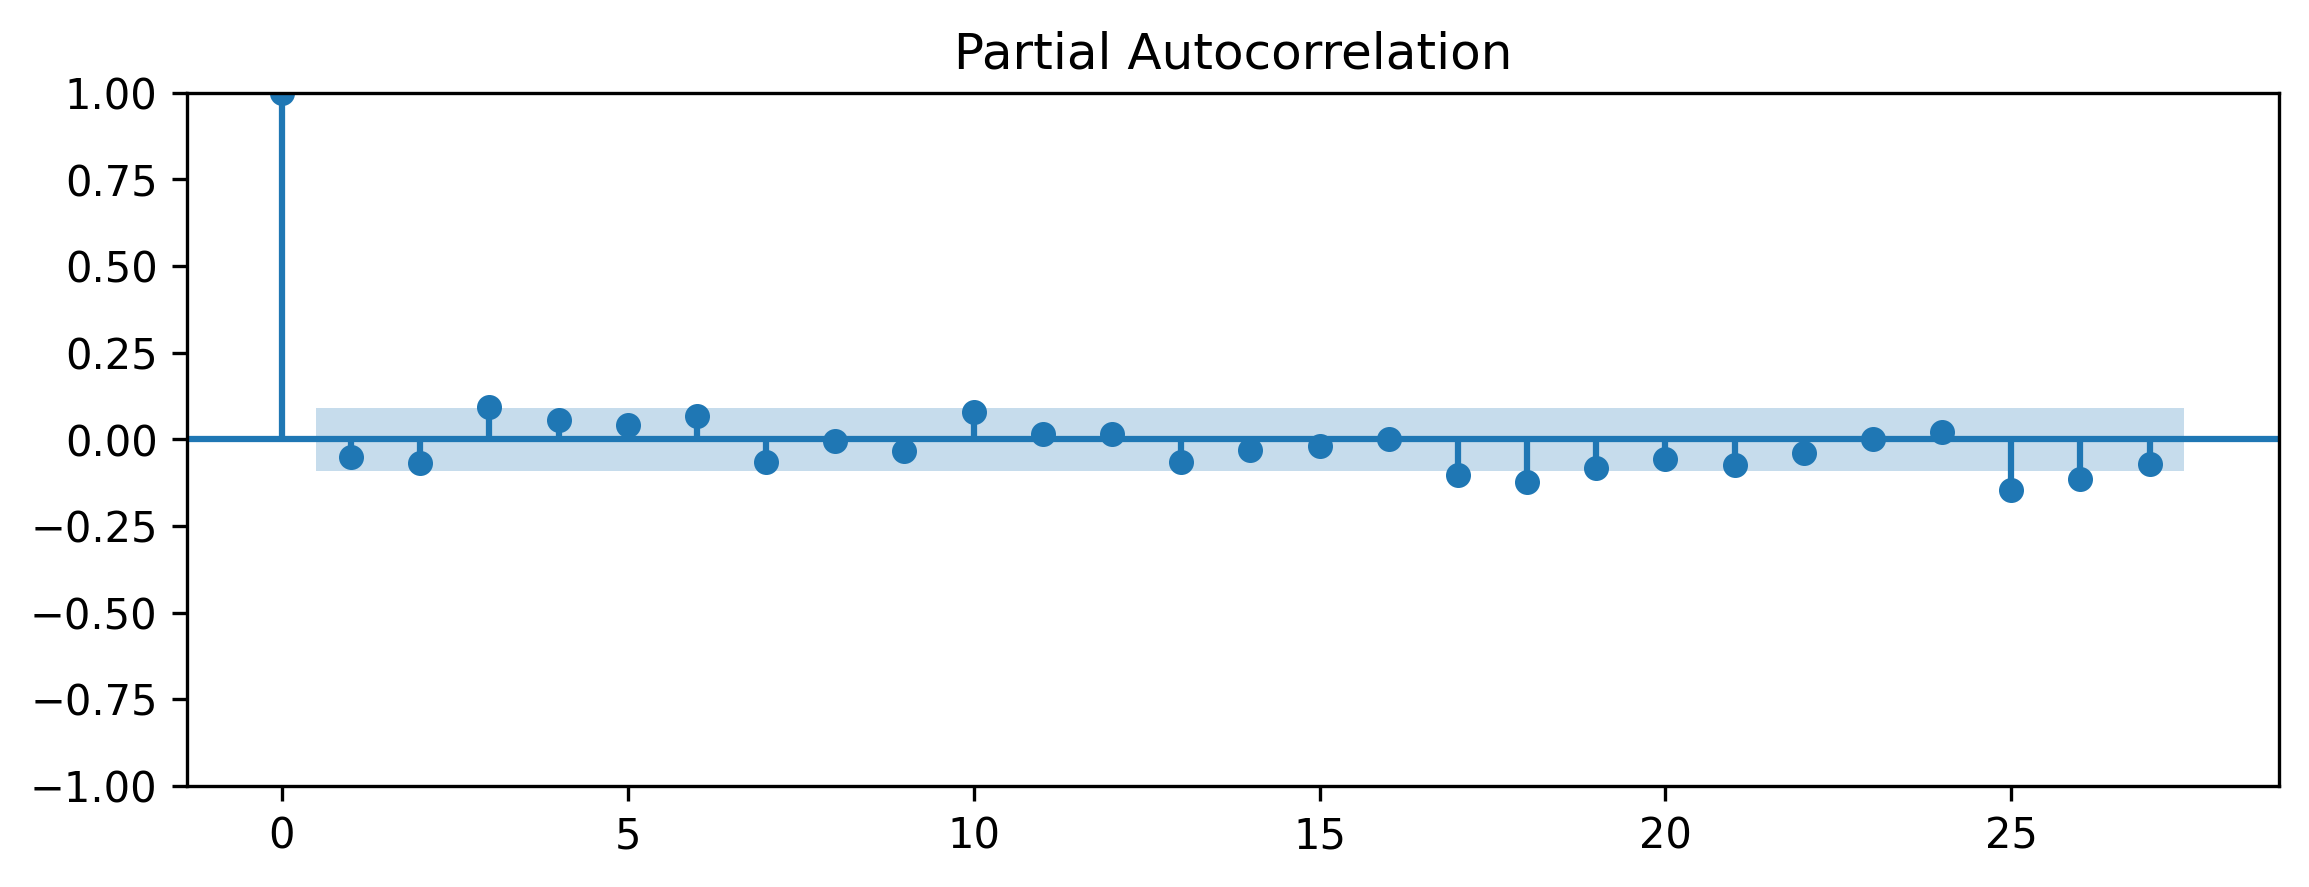

In [253]:
# 3 Validation
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals, method='ywm')

In [194]:
train

,y_train
date,
2005-01-01,0.478710
2005-01-09,0.488194
2005-01-17,0.491624
2005-01-25,0.479938
2005-02-02,0.475181
...,...
2014-11-25,0.728437
2014-12-03,0.744450
2014-12-11,0.702332


/Users/yokosukamori/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yokosukamori/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yokosukamori/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


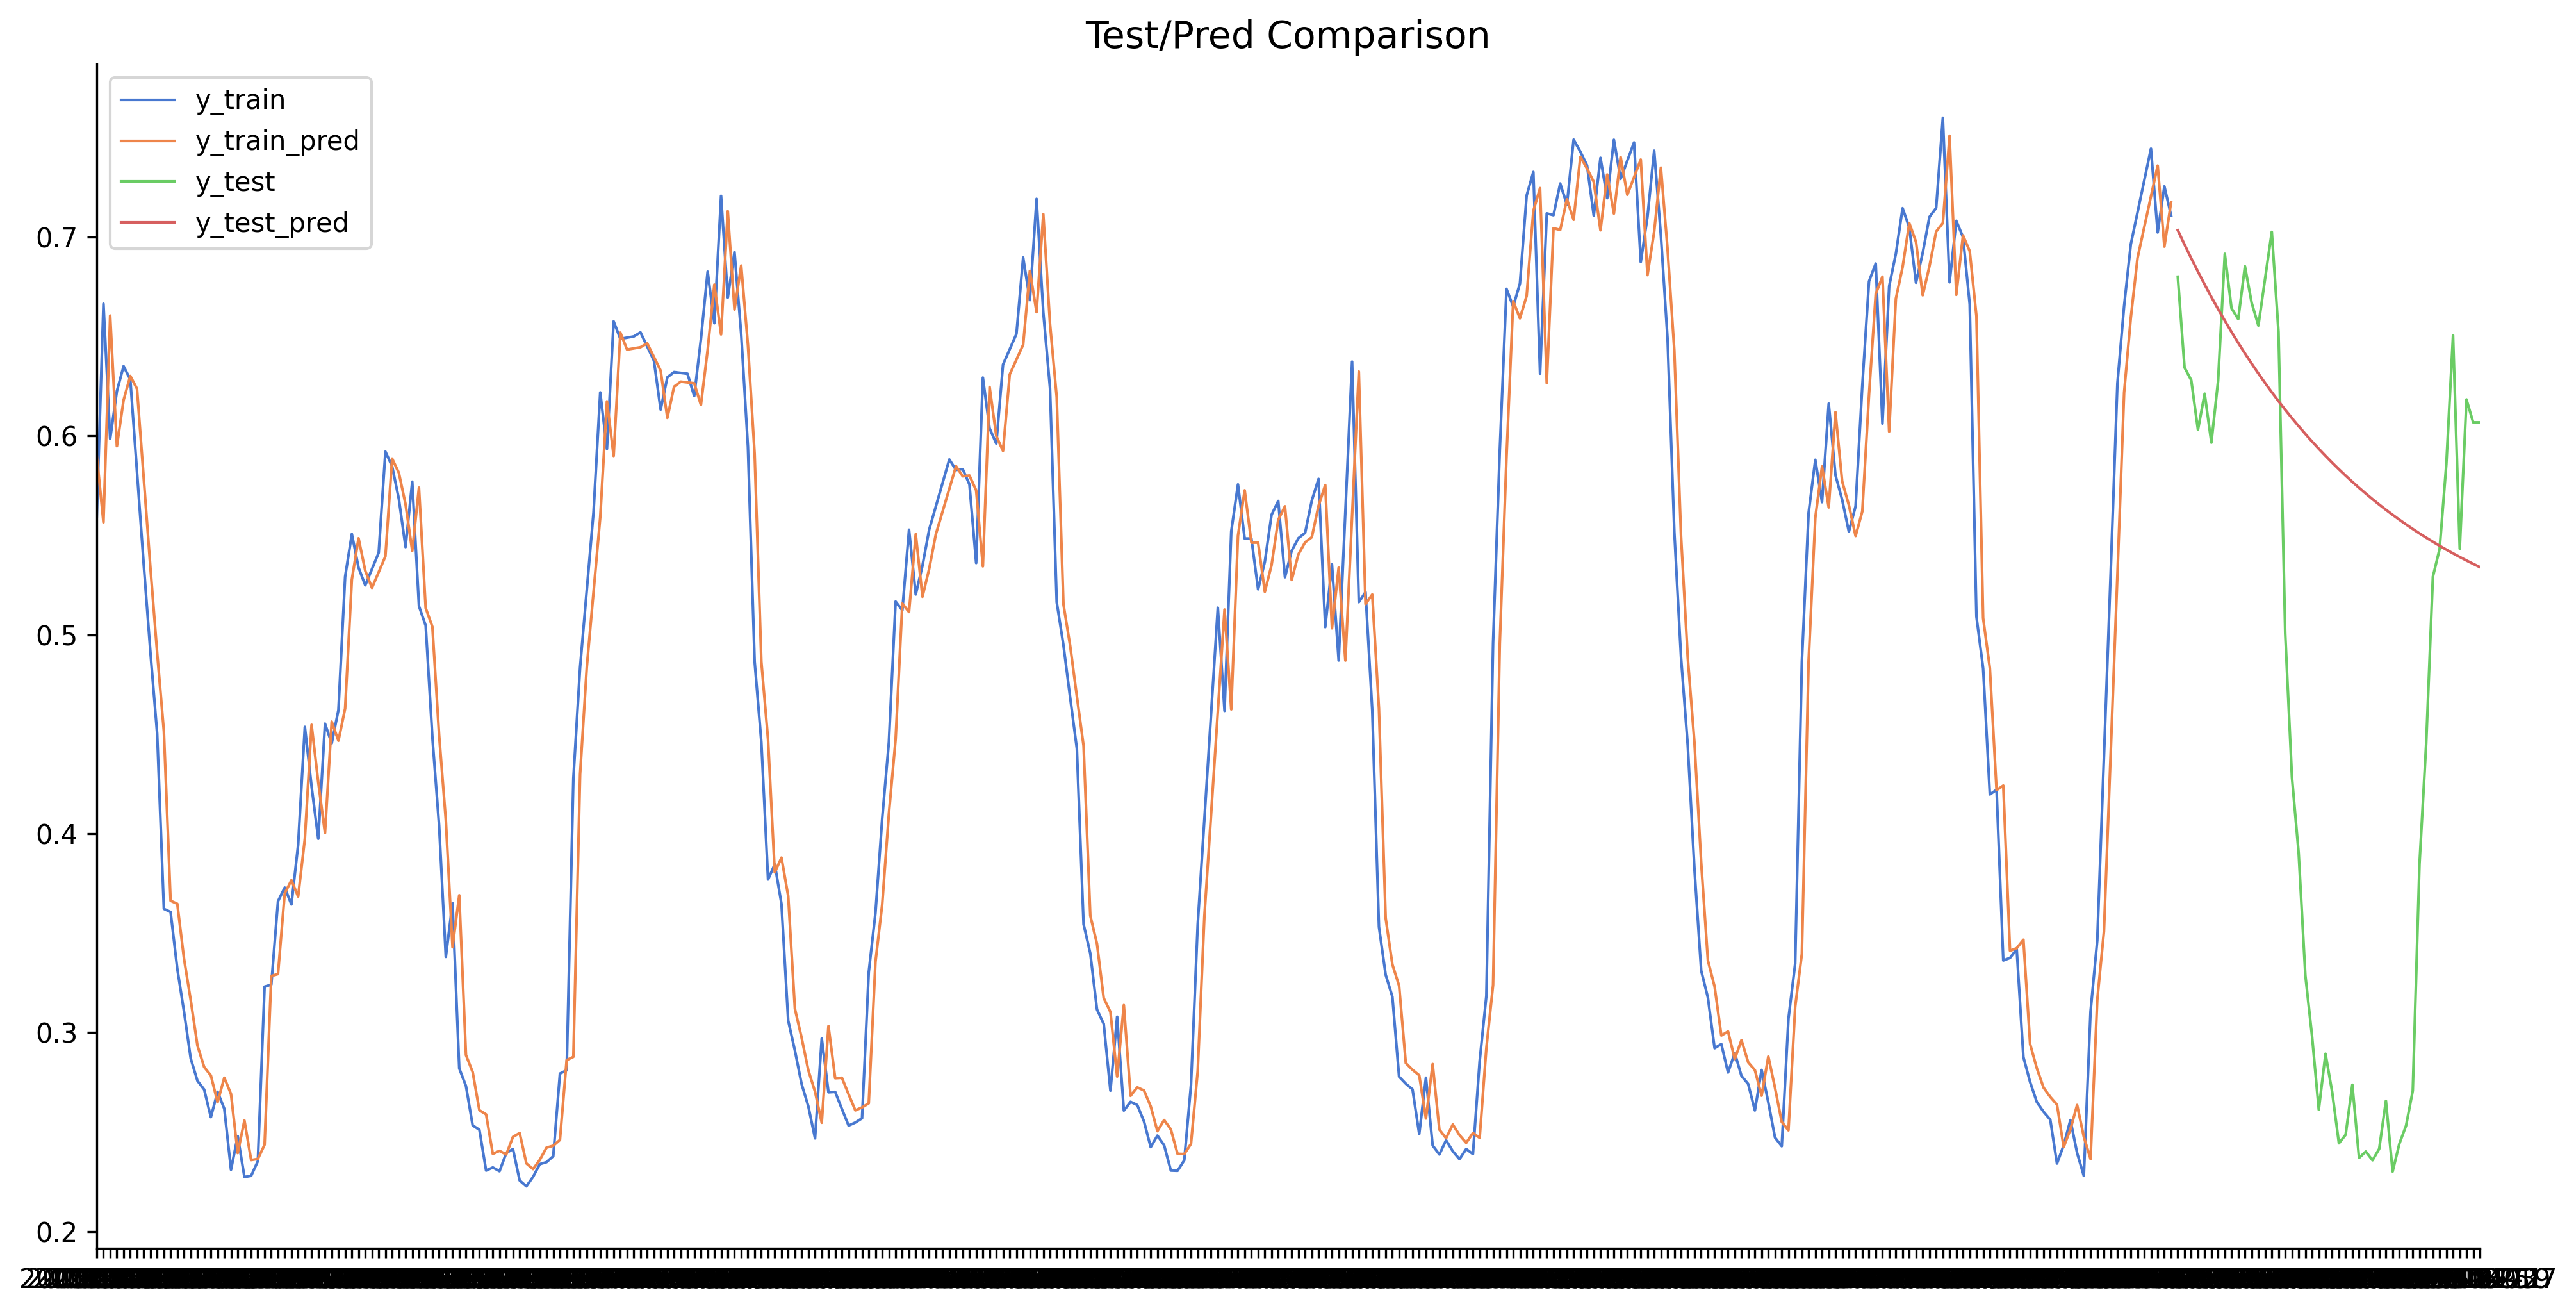

Median Absolute Percentage Error (MDAPE): 15.02 %
0.1833301766475661
mae - auto: 0.1573370407243195
mape - auto: 0.530325888237417
rmse - auto: 0.20255096583826915


In [263]:
# 4 Forecast
import seaborn as sns
# Predict the values on the training set
train_pred = model.predict(typ='levels')
start_index = len(train)
end_index = start_index + len(test) - 1
test_pred = model.predict(start=start_index, end=end_index, typ='levels')


train['y_train_pred'] = train_pred
test['y_test_pred'] = list(test_pred)
df_union = pd.concat([train, test])
df_union.rename(columns={'beer':'y_test'}, inplace=True)

# Print the predicted time-series
fig, ax = plt.subplots(figsize=(16, 8))
plt.title("Test/Pred Comparison", fontsize=14)
sns.despine();
sns.lineplot(data=df_union[['y_train', 'y_train_pred', 'y_test', 'y_test_pred']], linewidth=1.0, dashes=False, palette='muted')
ax.set_xlim([df_union.index[150],df_union.index.max()])
plt.legend()
plt.show()

def theil_u1_statistic(actual, forecast):
    # Calculate the squared forecast error
    forecast_error_squared = np.square(np.subtract(actual, forecast))
    
    # Calculate the squared difference of actual values (naive forecast error)
    naive_error_squared_1 = np.square(actual)
    naive_error_squared_2 = np.square(predicted)
    
    # Calculate Theil's U statistic
    u_statistic = np.sqrt(np.sum(forecast_error_squared)) / (np.sqrt(np.sum(naive_error_squared_1)) + np.sqrt(np.sum(naive_error_squared_2)))
    
    return u_statistic

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(test['y_test'], test['y_test_pred'])/ test['y_test'])) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

actual = test['y_test'].to_numpy()  # replace with your actual values
predicted = test['y_test_pred'].to_numpy()  # replace with your predicted values
theil_u = theil_u1_statistic(actual,predicted)
print(theil_u)

mae = mean_absolute_error(test['y_test'], test['y_test_pred'])
# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(test['y_test'], test['y_test_pred'])
rmse = np.sqrt(mean_squared_error(test['y_test'], test['y_test_pred']))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

/Users/yokosukamori/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yokosukamori/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


KeyError: 'y_test_pred'

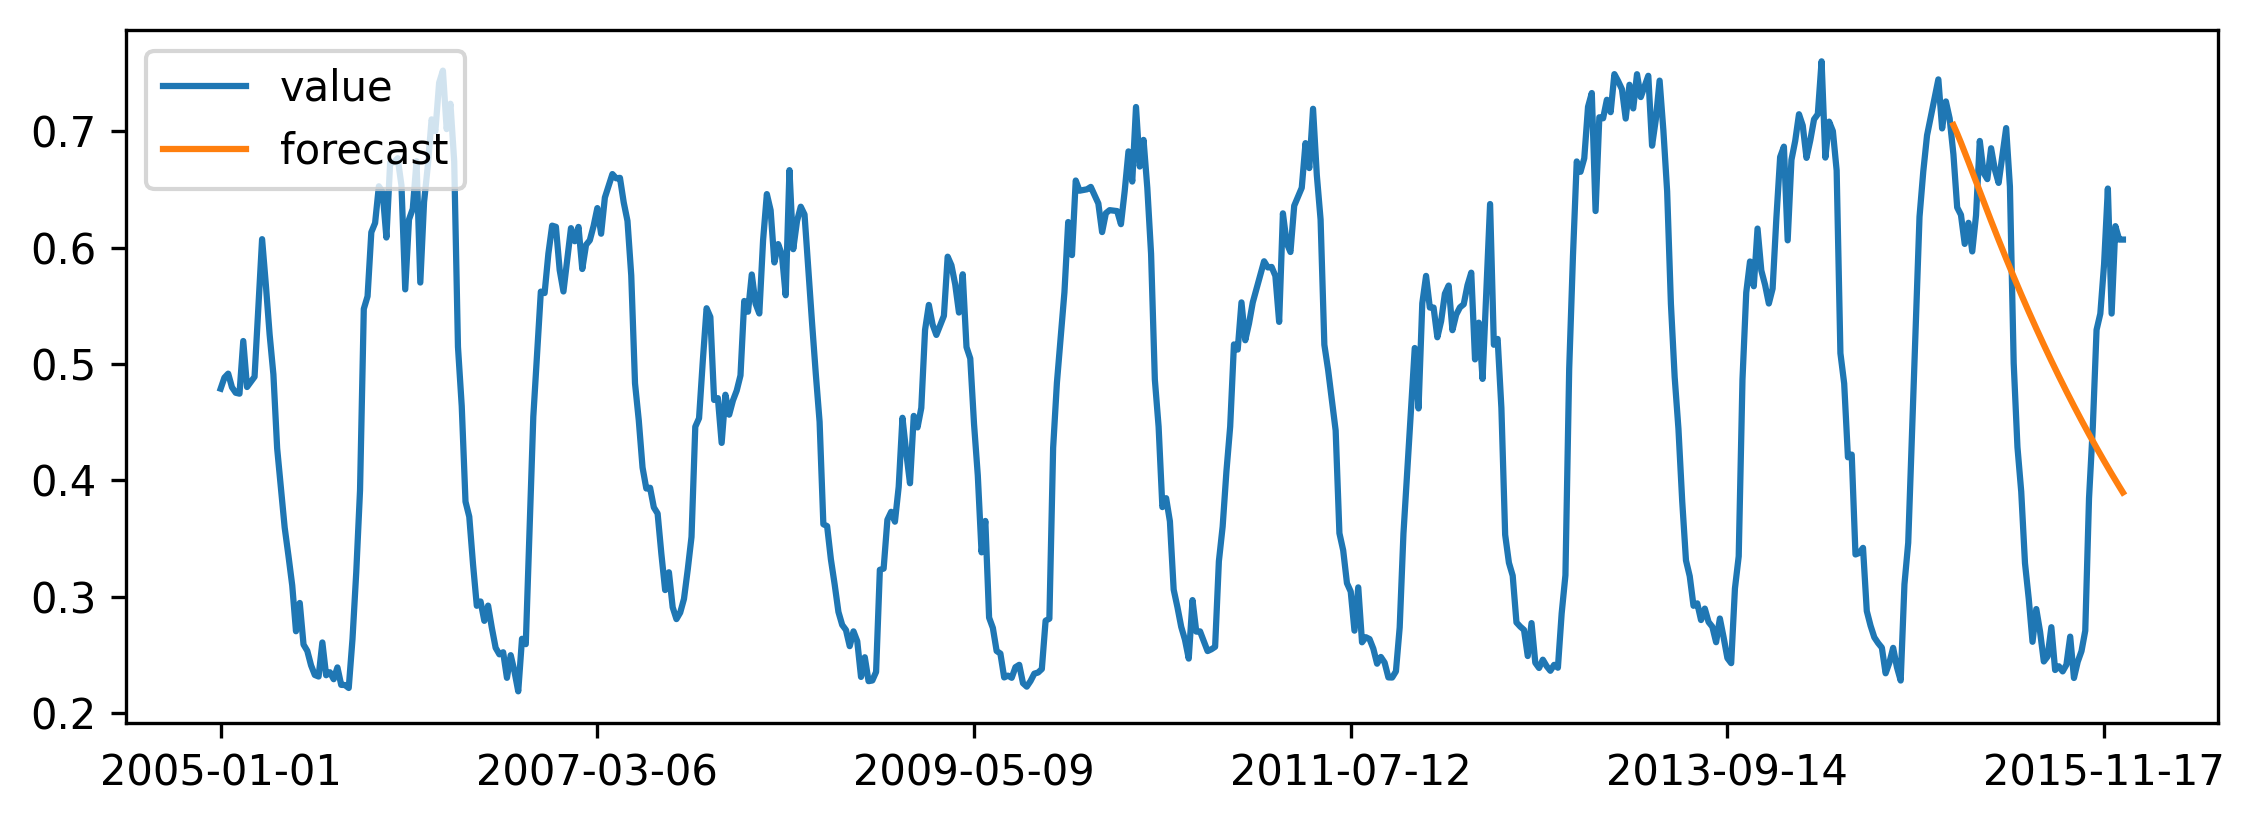

In [255]:
# X Forecast （Auto ARIMA）
import pmdarima as pm

pred_periods = 46
split_number = df['value'].count() - pred_periods # corresponds to a prediction horizion of 1 years
train = pd.DataFrame(df['value'][:split_number]).rename(columns={'value':'y_train'})
test = pd.DataFrame(df['value'][split_number:]).rename(columns={'value':'y_test'})

auto_arima = pm.auto_arima(train, stepwise=False, seasonal=False)
forecast_test = auto_arima.predict(n_periods=len(test))
df['forecast'] = [None]*len(train) + list(forecast_test)
ax = df.plot()
ax.legend(loc='upper left')

# Forecast Evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(test, forecast_test)
mape = mean_absolute_percentage_error(test, forecast_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')



In [217]:
# X Forecast Evaluation 2

actual = test['y_test'].to_numpy()  # replace with your actual values
predicted = forecast_test.to_numpy()  # replace with your predicted values

theil_u = theil_u1_statistic(actual,predicted)
theil_u

0.16342059535219625

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1659.887, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=669.910, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=102.443, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1639.452, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1589.842, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1603.501, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1695.813, Time=0.39 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1651.475, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1594.317, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1612.796, Time=0.16 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 2.102 seconds


/Users/yokosukamori/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yokosukamori/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


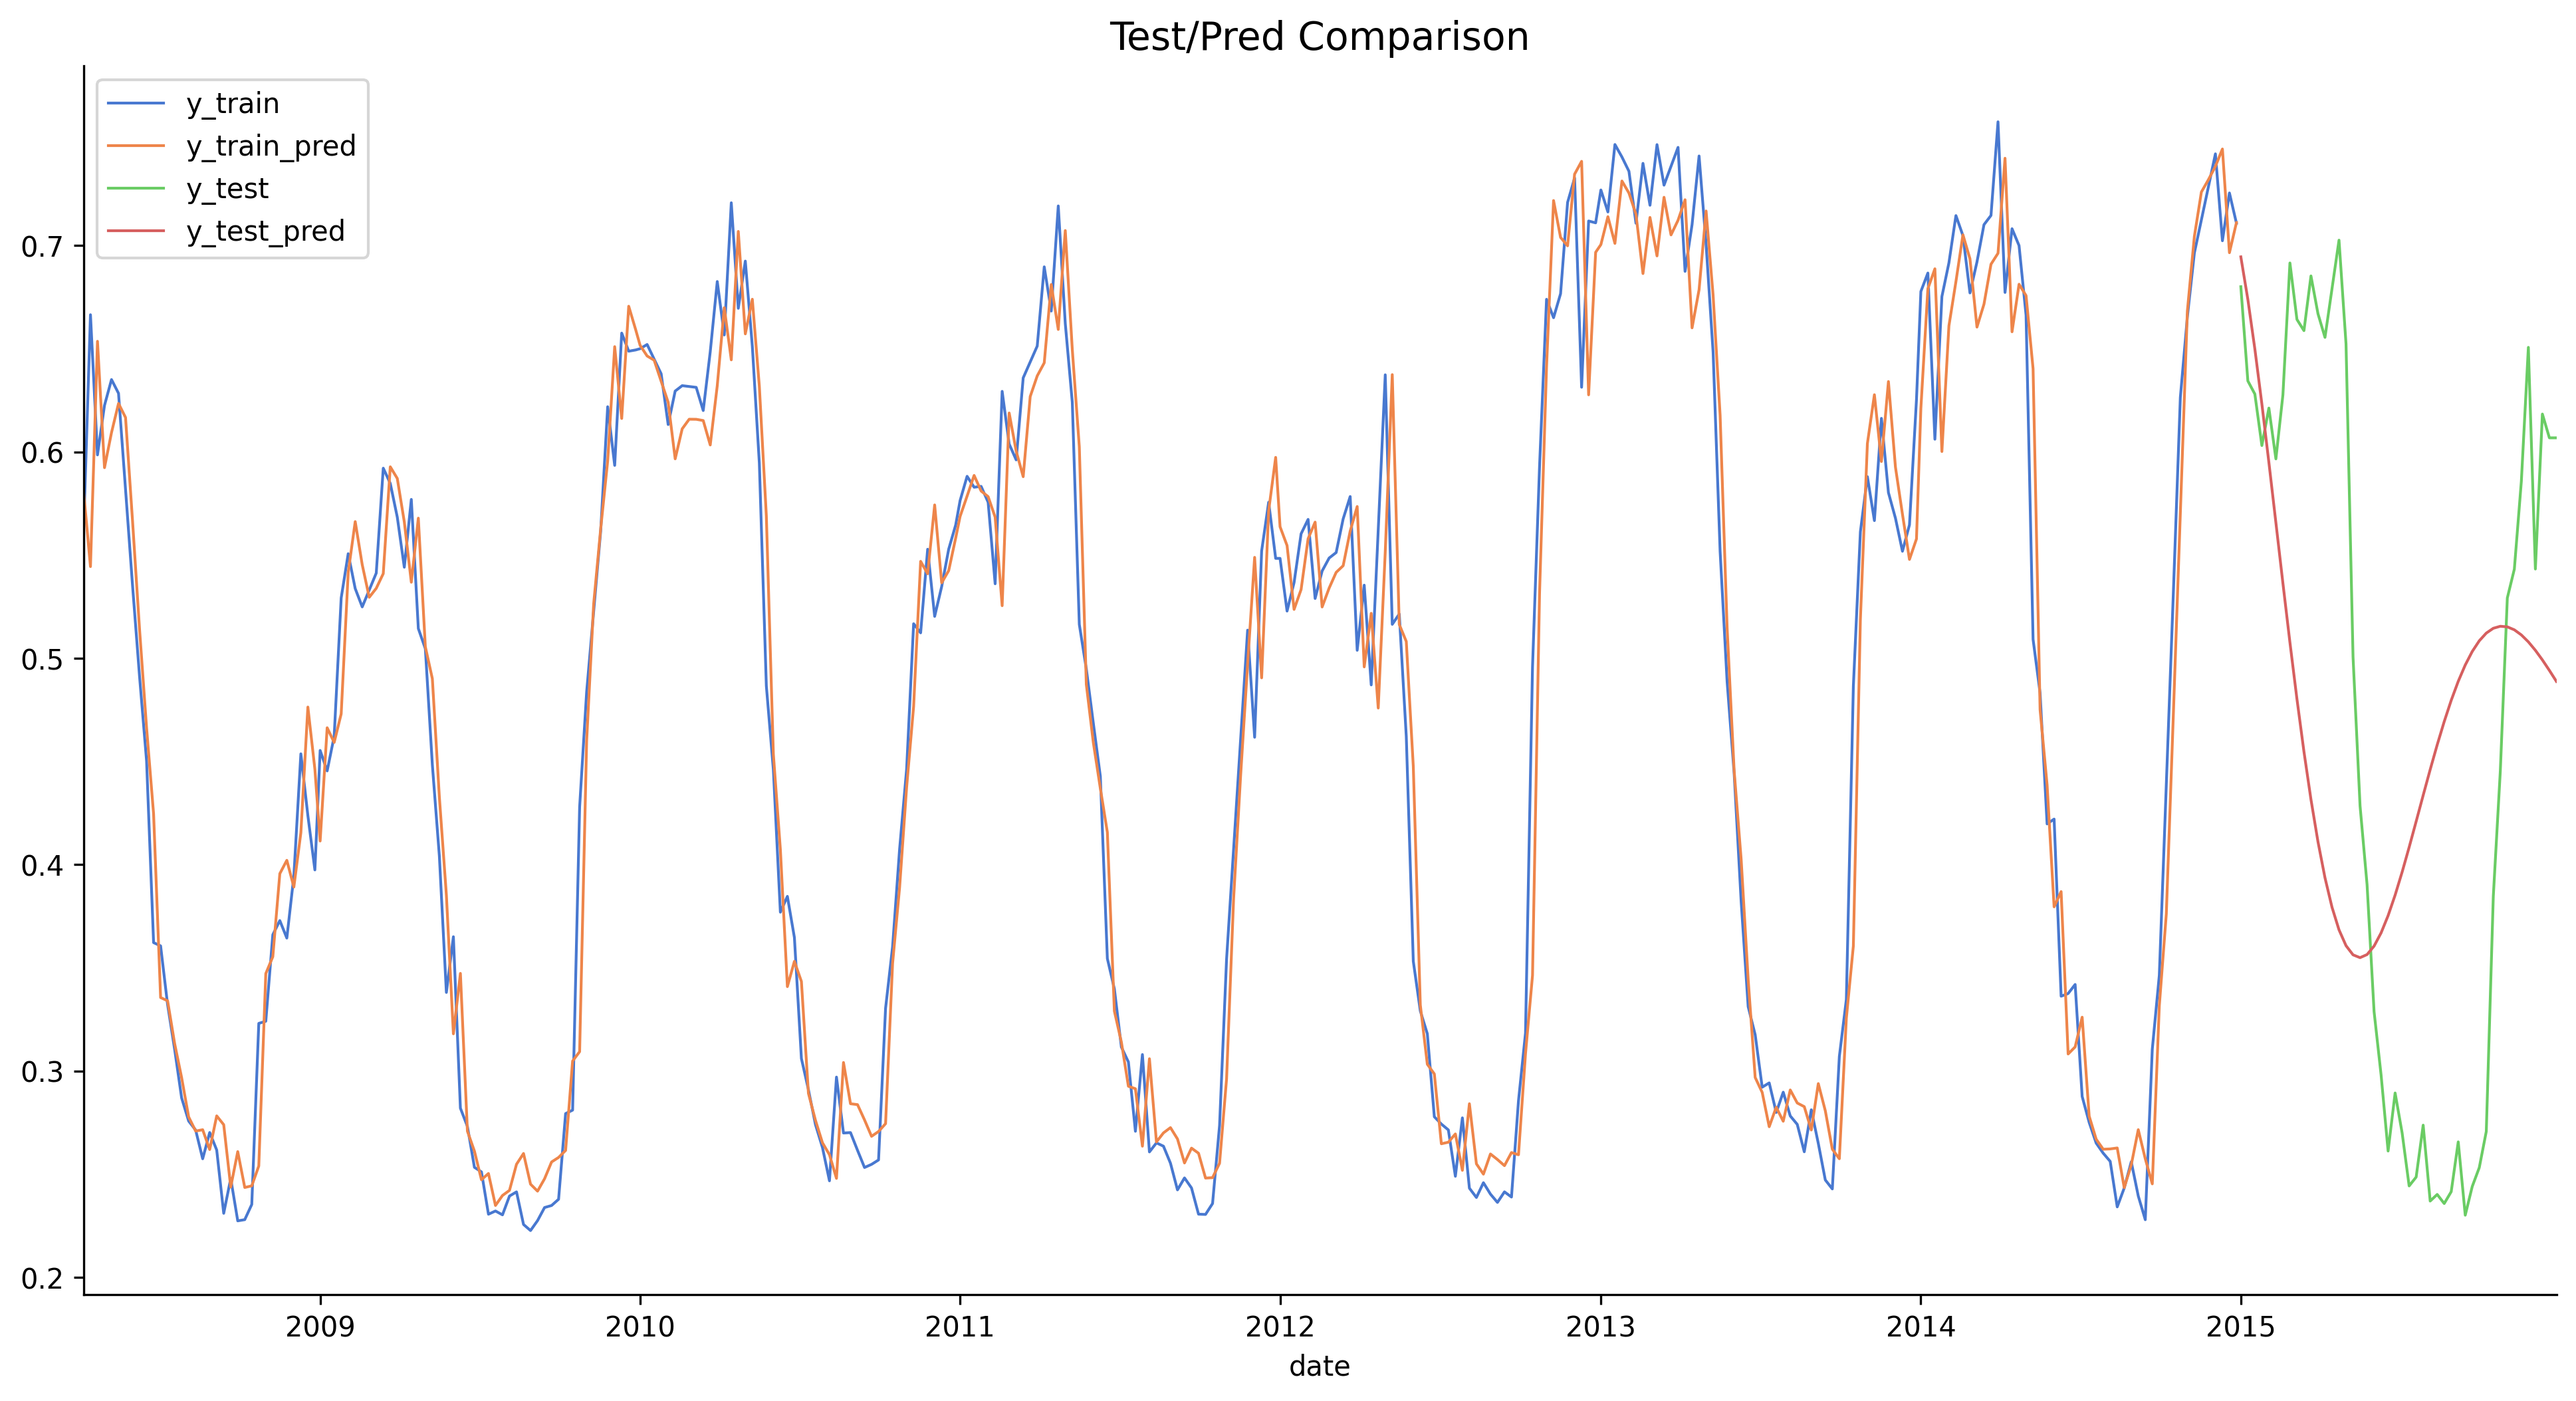

In [218]:
# X2 Forecast Auto ARIMA 2
import seaborn as sns

model_fit = pm.auto_arima(train, test='adf', 
                         max_p=2, max_d=1, max_q=2, 
                         seasonal=False, 
                         max_P=2, max_D=2, max_Q=2,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


# Generate in-sample Predictions
pred = model_fit.predict_in_sample(dynamic=False) # works only with auto-arima
train['y_train_pred'] = pred

# Generate prediction for n periods, 
# Predictions start from the last date of the training data
test_pred = model_fit.predict(n_periods=pred_periods, dynamic=False)
test['y_test_pred'] = list(test_pred)
df_union = pd.concat([train, test])
df_union.rename(columns={'beer':'y_test'}, inplace=True)

# Print the predicted time-series
fig, ax = plt.subplots(figsize=(16, 8))
plt.title("Test/Pred Comparison", fontsize=14)
sns.despine();
sns.lineplot(data=df_union[['y_train', 'y_train_pred', 'y_test', 'y_test_pred']], linewidth=1.0, dashes=False, palette='muted')
ax.set_xlim([df_union.index[150],df_union.index.max()])
plt.legend()
plt.show()

In [219]:
# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(test['y_test'], test['y_test_pred'])/ test['y_test'])) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

actual = test['y_test'].to_numpy()  # replace with your actual values
predicted = test['y_test_pred'].to_numpy()  # replace with your predicted values
theil_u = theil_u1_statistic(actual,predicted)
print(theil_u)

mae = mean_absolute_error(test['y_test'], test['y_test_pred'])
# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(test['y_test'], test['y_test_pred'])
rmse = np.sqrt(mean_squared_error(test['y_test'], test['y_test_pred']))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

Median Absolute Percentage Error (MDAPE): 29.9 %
0.17494246787647727
mae - auto: 0.14549700036488195
mape - auto: 0.393850821061479
rmse - auto: 0.17229896047337606
